## Load Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from Cython.Compiler.Naming import args_cname
from tensorboard.compat.tensorflow_stub.dtypes import float32
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Dict, Any, Optional
from dataclasses import dataclass
import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet34
import torch.optim as optim
import os
from torch.optim.lr_scheduler import MultiStepLR
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch, platform
print("PyTorch:", torch.__version__)
print("CUDA available?", torch.cuda.is_available())
print("torch.version.cuda:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device 0:", torch.cuda.get_device_name(0))
print("Python:", platform.python_version())

PyTorch: 2.9.0+cu130
CUDA available? True
torch.version.cuda: 13.0
Device count: 1
Device 0: NVIDIA GeForce RTX 5090
Python: 3.10.11


## Data loading

In [4]:
def load_dataset(file_path, val_ratio=0.2, random_state=42):
    dataset = np.load(file_path)
    Xtr, Str = dataset['Xtr'], dataset['Str']
    Xts, Yts = dataset['Xts'], dataset['Yts']

    # Shuffle & split (80% train, 20% validation)
    np.random.seed(random_state)
    indices = np.arange(len(Str))
    np.random.shuffle(indices)

    split_idx = int(len(Str) * (1 - val_ratio))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    X_train, y_train = Xtr[train_idx], Str[train_idx]
    X_val, y_val = Xtr[val_idx], Str[val_idx]

    return X_train, y_train, X_val, y_val, Xts, Yts

def reshape_mnist(*arrays):
    reshaped = []

    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = arr.reshape(-1, 1, 28, 28)
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            mean = torch.tensor(0.1307, dtype=torch.float32).view(1, 1, 1)
            std  = torch.tensor(0.3081, dtype=torch.float32).view(1, 1, 1)
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)

def reshape_cifar(*arrays):
    reshaped = []
    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
    std  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = np.transpose(arr, (0, 3, 1, 2))
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)


In [5]:
Xtr_03, Str_03, Xval_03, Sval_03, Xts_03, Yts_03 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.3.npz'))
Xtr_06, Str_06, Xval_06, Sval_06, Xts_06, Yts_06 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.6.npz'))
Xtr_cifar, Str_cifar, Xval_cifar, Sval_cifar, Xts_cifar, Yts_cifar = reshape_cifar(*load_dataset('datasets/CIFAR.npz'))

In [6]:
print("Xtr_03:", Xtr_03.shape)
print("Xtr_06:", Xtr_06.shape)
print("Xtr_cifar:", Xtr_cifar.shape)

Xtr_03: torch.Size([14400, 1, 28, 28])
Xtr_06: torch.Size([14400, 1, 28, 28])
Xtr_cifar: torch.Size([12000, 3, 32, 32])


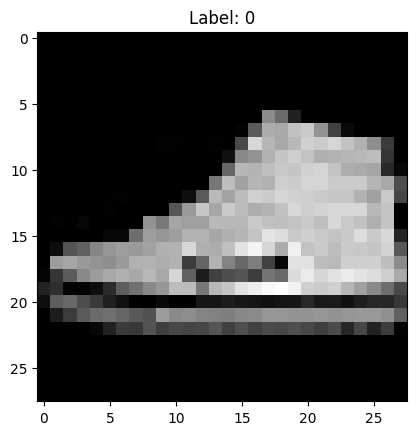

In [7]:
# Mnist data checking
plt.imshow(Xtr_03[114, -1, :, :], cmap='gray') #[pic number,_,_,_]
plt.title(f"Label: {Str_03[0]}")
plt.show()

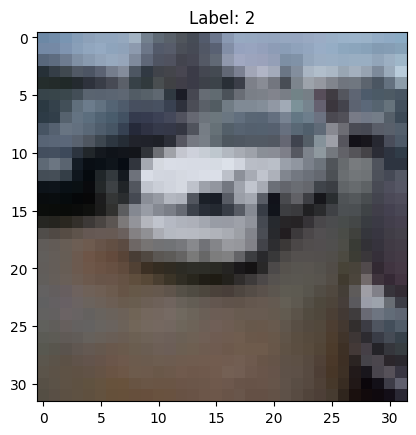

In [8]:
# CIFAR data checking
mean_test = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
std_test  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
test_cifar = Xtr_cifar[514] * std_test + mean_test
plt.imshow(np.transpose(test_cifar, (1, -1, 0)))
plt.title(f"Label: {Str_cifar[0]}")
plt.show()

# Main Program

## Classifier: ResNet-34

In [9]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes,mode='cifar'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        if mode == 'cifar':
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0, bias=False)
        else:
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        #self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        #self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(64*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, revision=True):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        #out = self.layer2(out)
        #out = self.layer3(out)
        #out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        clean = F.softmax(out, 1)

        return clean

def ResNet34(num_classes,mode):
  return ResNet(BasicBlock, [1], num_classes,mode)

In [10]:
# ---------------------------
# transition matrix
# ---------------------------
class sig_t(nn.Module):
    def __init__(self, device, num_classes, init=2):
        super(sig_t, self).__init__()

        C = num_classes
        self.register_parameter(name='w', param=nn.parameter.Parameter(-init*torch.ones(num_classes, num_classes)))

        self.w.to(device)
        co = torch.full((C, C), 1.0 / (C - 1))
        self.co = co.to(device)
        self.identity = torch.eye(num_classes).to(device)


    def forward(self):
        sig = torch.sigmoid(self.w)
        T = self.identity.detach() + sig * self.co.detach()
        T = F.normalize(T, p=1, dim=1)
        return T

def logit(p, eps=1e-12):
    p = torch.clamp(p, eps, 1 - eps)
    return torch.log(p) - torch.log(1 - p)

In [11]:
def warmup(train_data, train_loader, model,optimizer_model, loss_func_ce):

    model.train()
    train_loss = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_model.zero_grad()

        clean = model(batch_x)

        ce_loss = loss_func_ce(clean.log(), batch_y.long())
        res = torch.mean(torch.sum(clean.log() * clean, dim=1))
        loss = ce_loss + res

        train_loss += loss.item()

        loss.backward()
        optimizer_model.step()


    print('Warmup Loss: {:.6f}'.format(train_loss / (len(train_data))*Cfg.batch_size))


def train(train_data, train_loader,model,trans_for,trans_back,optimizer_es,optimizer_trans_for,optimizer_trans_back,scheduler1,scheduler2,scheduler3,loss_func_ce):
    model.train()
    trans_for.train()
    trans_back.train()

    train_loss = 0.
    train_acc = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = torch.zeros(batch_x.size(0), Cfg.num_classes).scatter_(1, batch_y.view(-1,1), 1)
        batch_y = batch_y.to(device)

        clean = model(batch_x)
        noise = F.softmax(batch_y, 1)

        t_for = trans_for()
        t_back = trans_back()

        out = torch.mm(clean, t_for)
        out1 = torch.mm(noise, t_back)

        noise_y = torch.max(noise, dim=1)[1].detach()
        clean_y = torch.max(clean, dim=1)[1].detach()
        ce_loss = loss_func_ce(out.log(), noise_y.long())
        ce_loss_1 =  loss_func_ce(out1.log(), clean_y.long())

        for_back_1 = torch.mm(clean, t_for.detach())
        for_back = torch.mm(for_back_1, t_back.detach())

        loss_for_back = loss_func_ce(for_back.log(), clean_y.long())  #loss_func_ce(for_back.log(), clean_y.long()) #-torch.mean(torch.sum(for_back.log() * clean,dim=1)) #


        loss = ce_loss  + ce_loss_1+ Cfg.lam * loss_for_back

        train_loss += loss.item()

        pred = torch.max(out, 1)[1]
        train_correct = (pred == noise_y).sum()
        train_acc += train_correct.item()

        optimizer_es.zero_grad()
        optimizer_trans_for.zero_grad()
        optimizer_trans_back.zero_grad()

        loss.backward()

        optimizer_es.step()
        optimizer_trans_for.step()
        optimizer_trans_back.step()

    print('Train Loss: {:.6f},  Acc: {:.6f}'.format(train_loss / (len(train_data))*Cfg.batch_size,  train_acc / (len(train_data))))

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()


def val(val_data, val_loader, model, trans, loss_func_ce):
    val_acc = 0.
    val_loss = 0.

    with torch.no_grad():
        model.eval()
        trans.eval()

        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)
            t = trans()

            out = torch.mm(clean, t)
            loss = loss_func_ce(out.log(), batch_y.long())
            val_loss += loss.item()
            pred = torch.max(out, 1)[1]
            val_correct = (pred == batch_y).sum()
            val_acc += val_correct.item()


    print('Val Loss: {:.6f}, Acc: {:.6f}'.format(val_loss / (len(val_data))*Cfg.batch_size, val_acc / (len(val_data))))
    return val_loss / (len(val_data))

def test(test_data, test_loader, model, loss_func_ce):
    eval_loss = 0.
    eval_acc = 0.

    with torch.no_grad():
        model.eval()

        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)

            loss = loss_func_ce(clean.log(), batch_y.long())
            eval_loss += loss.item()
            pred = torch.max(clean, 1)[1]
            eval_correct = (pred == batch_y).sum()
            eval_acc += eval_correct.item()

        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(test_data)) * Cfg.batch_size,
                                                      eval_acc / (len(test_data))))
    return eval_acc / (len(test_data))


In [12]:
def main(dataset_name):

      try:
          del model
      except:
          pass
      try:
          del trans; del trans_1
      except:
          pass
      gc.collect()
      if torch.cuda.is_available():
        torch.cuda.empty_cache()

      #init
      criterion = torch.nn.NLLLoss(reduction="mean")
      model = ResNet34(Cfg.num_classes,dataset_name)
      milestones = Cfg.milestones

      if dataset_name.lower() in ("mnist03"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.3.npz"))
      elif dataset_name.lower() in ("mnist06"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.6.npz"))
      elif dataset_name.lower() in ("cifar"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_cifar(*load_dataset("datasets/CIFAR.npz"))
      else:
          raise ValueError(f"Unsupported dataset: {dataset_name}")

      train_data = TensorDataset(Xtr, ytr)
      val_data = TensorDataset(Xva, yva)
      test_data = TensorDataset(Xte, yte)

      trans = sig_t(device, Cfg.num_classes)
      trans_1 = sig_t(device, Cfg.num_classes)
      optimizer_trans = optim.AdamW(trans.parameters(), lr=Cfg.lr, weight_decay=0)
      optimizer_trans_1 = optim.AdamW(trans_1.parameters(), lr=Cfg.lr, weight_decay=0)


      #optimizer and StepLR
      optimizer_es = optim.AdamW(model.parameters(), lr=Cfg.lr, weight_decay=Cfg.weight_decay)
      scheduler1 = MultiStepLR(optimizer_es, milestones=milestones, gamma=0.1)
      scheduler2 = MultiStepLR(optimizer_trans, milestones=milestones, gamma=0.1)
      scheduler3 = MultiStepLR(optimizer_trans_1, milestones=milestones, gamma=0.1)


      #data_loader
      train_loader = DataLoader(dataset=train_data,
                                batch_size=Cfg.batch_size,
                                shuffle=True,
                                num_workers=4,
                                drop_last=False)

      val_loader = DataLoader(dataset=val_data,
                              batch_size=Cfg.batch_size,
                              shuffle=False,
                              num_workers=4,
                              drop_last=False)

      test_loader = DataLoader(dataset=test_data,
                              batch_size=Cfg.batch_size,
                              num_workers=4,
                              drop_last=False)

      #cuda
      if torch.cuda.is_available:
          model = model.to(device)
          trans = trans.to(device)
          trans_1 = trans_1.to(device)

      best_acc = 0
      best_acc_back = 0
      #warmup
      for epoch in range(Cfg.warmup_epoch):
          print('epoch[{}], Warmup'.format(epoch + 1))
          warmup(train_data, train_loader, model,optimizer_es, criterion)
          val(val_data, val_loader, model, trans,criterion)
          acc = test(test_data, test_loader, model,criterion)
          if acc> best_acc:
              best_acc = acc
          print('Best_acc: {:.6f}'.format(best_acc))

      acc_list = []
      early_stop = 0
      best_val_acc = -10000

      #train
      for epoch in range(Cfg.n_epoch):
          print('epoch[{}], Train'.format(epoch+1))
          train(train_data,train_loader,model,trans,trans_1,optimizer_es,optimizer_trans,optimizer_trans_1,scheduler1,scheduler2,scheduler3,criterion)
          val_loss = val(val_data, val_loader, model, trans,criterion)
          acc = test(test_data, test_loader, model,criterion)

          acc_list.append(acc)


          if acc> best_acc and val_loss > best_val_acc:
              best_acc = acc
              best_val_acc = val_loss
              early_stop = 0
              print('Best_acc: {:.6f}'.format(best_acc))
          else:
              early_stop += 1
              print('Best_acc: {:.6f}'.format(best_acc))
              if early_stop >= Cfg.es_epoch:
                print(f"⏹ Early stopping at epoch {epoch+1} (best val_acc={best_acc:.6f})")
                break

      with torch.no_grad():
        Tf_np = trans().detach().cpu().numpy()
        Tb_np = trans_1().detach().cpu().numpy()

      print('Best_acc: ', best_acc)
      return best_acc,acc_list,Tf_np, Tb_np


# Running

In [16]:
# ---------------------------
# Config
# ---------------------------
@dataclass
class Cfg:
    num_classes: int = 3
    epochs: int = 60
    batch_size: int = 128
    lr: float = 0.005
    momentum: float = 0.9
    weight_decay: float = 1e-4
    milestones: Tuple[int, int] = (30, 60)
    lam: float = 0.6                 # weight for cycle term
    n_epoch: int = 120
    warmup_epoch: int = 10
    es_epoch: int = 10
    anchor: bool = False
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
best,acc_list, Tf, Tb = main(dataset_name="mnist06")

epoch[1], Warmup
Warmup Loss: 0.008562
Val Loss: 1.132694, Acc: 0.353056
Test Loss: 1.098344, Acc: 0.657000
Best_acc: 0.657000
epoch[2], Warmup
Warmup Loss: 0.003345
Val Loss: 1.131911, Acc: 0.353056
Test Loss: 1.093238, Acc: 0.499667
Best_acc: 0.657000
epoch[3], Warmup
Warmup Loss: 0.001501
Val Loss: 1.129710, Acc: 0.370278
Test Loss: 1.064023, Acc: 0.840667
Best_acc: 0.840667
epoch[4], Warmup
Warmup Loss: 0.003052
Val Loss: 1.133158, Acc: 0.358611
Test Loss: 1.057501, Acc: 0.590667
Best_acc: 0.840667
epoch[5], Warmup
Warmup Loss: 0.003746
Val Loss: 1.132311, Acc: 0.327778
Test Loss: 1.084826, Acc: 0.350333
Best_acc: 0.840667
epoch[6], Warmup
Warmup Loss: 0.001672
Val Loss: 1.129552, Acc: 0.361667
Test Loss: 1.066706, Acc: 0.561667
Best_acc: 0.840667
epoch[7], Warmup
Warmup Loss: -0.001112
Val Loss: 1.130423, Acc: 0.358889
Test Loss: 1.048753, Acc: 0.623667
Best_acc: 0.840667
epoch[8], Warmup
Warmup Loss: 0.000078
Val Loss: 1.132206, Acc: 0.339444
Test Loss: 1.068425, Acc: 0.508667
Be

In [18]:
print("\n=== Forward T (clean→noisy) ===")
print(np.array_str(Tf, precision=3, suppress_small=True, max_line_width=180))
print("row sums:", np.round(Tf.sum(axis=1), 3))

print("\n=== Backward T (noisy→clean) ===")
print(np.array_str(Tb, precision=3, suppress_small=True, max_line_width=180))
print("row sums:", np.round(Tb.sum(axis=1), 3))


=== Forward T (clean→noisy) ===
[[0.53  0.235 0.235]
 [0.008 0.943 0.049]
 [0.007 0.05  0.942]]
row sums: [1. 1. 1.]

=== Backward T (noisy→clean) ===
[[0.992 0.004 0.004]
 [0.308 0.69  0.002]
 [0.308 0.002 0.69 ]]
row sums: [1. 1. 1.]
